In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import random
import cv2
import json
import shutil
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from ultralytics import YOLO
from tqdm import tqdm
import time

# Set random seed for reproducibility
random.seed(42)

# Check if CUDA is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Check if running on Kaggle
is_kaggle = os.path.exists('/kaggle/input')
print(f"Running on Kaggle: {is_kaggle}")

# Set paths based on environment
if is_kaggle:
    # Kaggle paths
    root_dir = '/kaggle/input/chessred'
    annotations_file = os.path.join(root_dir, 'annotations.json')
    image_dir = os.path.join(root_dir, 'chessred2k')
else:
    # Local paths
    root_dir = '.'
    annotations_file = os.path.join('chessred2k', 'annotations.json')
    image_dir = 'chessred2k'

# Check if required files and directories exist
if os.path.exists(image_dir):
    print(f"Found images directory: {image_dir}")
else:
    print(f"Images directory not found at {image_dir}")

if os.path.exists(annotations_file):
    print(f"Found annotations file: {annotations_file}")
else:
    print(f"Annotations file not found at {annotations_file}")

Using cuda device
Running on Kaggle: True
✓ Found images directory: /kaggle/input/chessred/chessred2k
✓ Found annotations file: /kaggle/input/chessred/annotations.json


In [23]:
def chesspos2number(chesspos):
    """Convert chess position (e.g., 'a1') to zero-indexed row and column"""
    col = ord(chesspos[0]) - ord('a')
    row = int(chesspos[1]) - 1
    return row, col

class ChessDatasetWithBBoxes(Dataset):
    """Chess dataset that uses the actual bounding boxes from annotations"""
    
    def __init__(self, image_dir, annotations_file, partition='train', transform=None):
        """
        Initialize the dataset with actual bounding box annotations.
        
        Args:
            image_dir: Directory containing the dataset images
            annotations_file: Path to annotations.json file
            partition: 'train', 'valid' or 'test'
            transform: Optional transforms to apply to images
        """
        self.image_dir = image_dir
        self.transform = transform
        
        # Load annotations
        print(f"Loading annotations from {annotations_file}")
        self.anns = json.load(open(annotations_file))
        self.categories = [c['name'] for c in self.anns['categories']]
        
        # Map category IDs to names for easier reference
        self.category_map = {}
        for cat in self.anns['categories']:
            self.category_map[cat['id']] = cat['name']
        
        # Load image information
        self.ids = []
        self.file_names = []
        for img in self.anns['images']:
            self.file_names.append(img['path'])
            self.ids.append(img['id'])
        
        self.file_names = np.asarray(self.file_names)
        self.ids = np.asarray(self.ids)
        
        # Initialize board state
        self.boards = torch.zeros((len(self.file_names), 8, 8))
        
        # Create a mapping from image ID to annotations
        self.img_to_annots = {img_id: [] for img_id in self.ids}
        
        # Process piece annotations with bounding boxes
        for piece in self.anns['annotations']['pieces']:
            img_id = piece['image_id']
            idx = np.where(self.ids == img_id)[0][0]
            
            # Record board position
            row, col = chesspos2number(piece['chessboard_position'])
            self.boards[idx][row][col] = 1
            
            # Store the annotation with the image
            if 'bbox' in piece:
                self.img_to_annots[img_id].append({
                    'bbox': piece['bbox'],
                    'category_id': piece['category_id'],
                    'position': piece['chessboard_position']
                })
        
        # Get the split indices for the specified partition
        if partition == 'train':
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['train']['image_ids']).astype(int)
        elif partition == 'valid':
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['val']['image_ids']).astype(int)
        else:
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['test']['image_ids']).astype(int)
        
        # Filter data based on split
        intersect = np.isin(self.ids, self.split_ids)
        self.split_ids = np.where(intersect)[0]
        self.file_names = self.file_names[self.split_ids]
        self.boards = self.boards[self.split_ids]
        self.ids = self.ids[self.split_ids]
        
        # Count pieces for each image
        self.num_pieces = torch.sum(self.boards.view(len(self.boards), 64), axis=-1)
        
        print(f"Number of {partition} images: {len(self.file_names)}")
        
        # Print piece count statistics
        piece_counts = self.num_pieces.numpy().astype(int)
        print(f"Piece count statistics - min: {np.min(piece_counts)}, max: {np.max(piece_counts)}, mean: {np.mean(piece_counts):.2f}")
        
        # Verify we have annotations
        total_boxes = sum(len(self.img_to_annots[img_id]) for img_id in self.ids)
        print(f"Total bounding boxes in {partition} set: {total_boxes}")

        # Print a sample file path to help with debugging
        if len(self.file_names) > 0:
            print(f"Sample image path: {self.file_names[0]}")

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, i):
        try:
            # Get image path
            image_path = os.path.join(self.image_dir, self.file_names[i])
            
            # Load image
            if not os.path.exists(image_path):
                print(f"Image not found: {image_path}")
                image = np.zeros((640, 640, 3), dtype=np.uint8)
            else:
                image = cv2.imread(image_path)
                if image is None:
                    print(f"Failed to read image: {image_path}")
                    image = np.zeros((640, 640, 3), dtype=np.uint8)
                else:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Get annotations for this image
            img_id = self.ids[i]
            annotations = self.img_to_annots[img_id]
            
            # Count pieces from board state
            num_pieces = int(self.num_pieces[i].item())
            
            # Get original image dimensions for normalization
            original_h, original_w = image.shape[:2]
            
            # Apply transform to image if specified
            if self.transform:
                image = self.transform(image)
            
            return image, num_pieces, annotations, (original_h, original_w), image_path
            
        except Exception as e:
            print(f"Error loading image {i}: {str(e)}")
            # Return placeholder if there's an error
            return np.zeros((640, 640, 3), dtype=np.uint8), 0, [], (0, 0), ""

In [24]:
# Create dataset instances using the global paths
train_dataset = ChessDatasetWithBBoxes(
    image_dir=image_dir,
    annotations_file=annotations_file,
    partition='train'
)

valid_dataset = ChessDatasetWithBBoxes(
    image_dir=image_dir,
    annotations_file=annotations_file,
    partition='valid'
)

test_dataset = ChessDatasetWithBBoxes(
    image_dir=image_dir,
    annotations_file=annotations_file,
    partition='test'
)

# Let's inspect the annotations for a single image
if len(train_dataset) > 0:
    sample_idx = 0
    img, count, annotations, dims, img_path = train_dataset[sample_idx]

    print(f"\nSample image from training set:")
    print(f"Image path: {img_path}")
    print(f"Dimensions: {dims}")
    print(f"Piece count: {count}")
    print(f"Number of bounding boxes: {len(annotations)}")

    if annotations:
        print("\nExample annotations:")
        for i, ann in enumerate(annotations[:3]):  # Show first 3
            print(f"Annotation {i+1}:")
            print(f"  Position: {ann['position']}")
            print(f"  Category ID: {ann['category_id']}")
            print(f"  Bounding box: {ann['bbox']}")
    else:
        print("No annotations found for this image.")
else:
    print("No training images found.")

Loading annotations from /kaggle/input/chessred/annotations.json
Number of train images: 1442
Piece count statistics - min: 8, max: 32, mean: 21.31
Total bounding boxes in train set: 30723
Sample image path: images/19/G019_IMG000.jpg
Loading annotations from /kaggle/input/chessred/annotations.json
Number of valid images: 330
Piece count statistics - min: 6, max: 32, mean: 18.58
Total bounding boxes in valid set: 6132
Sample image path: images/6/G006_IMG000.jpg
Loading annotations from /kaggle/input/chessred/annotations.json
Number of test images: 306
Piece count statistics - min: 6, max: 32, mean: 20.57
Total bounding boxes in test set: 6294
Sample image path: images/0/G000_IMG000.jpg

Sample image from training set:
Image path: /kaggle/input/chessred/chessred2k/images/19/G019_IMG000.jpg
Dimensions: (3024, 3024)
Piece count: 32
Number of bounding boxes: 32

Example annotations:
Annotation 1:
  Position: a8
  Category ID: 7
  Bounding box: [2236.44, 2033.06, 171.61, 211.03]
Annotation 2


Visualizing samples with bounding boxes:


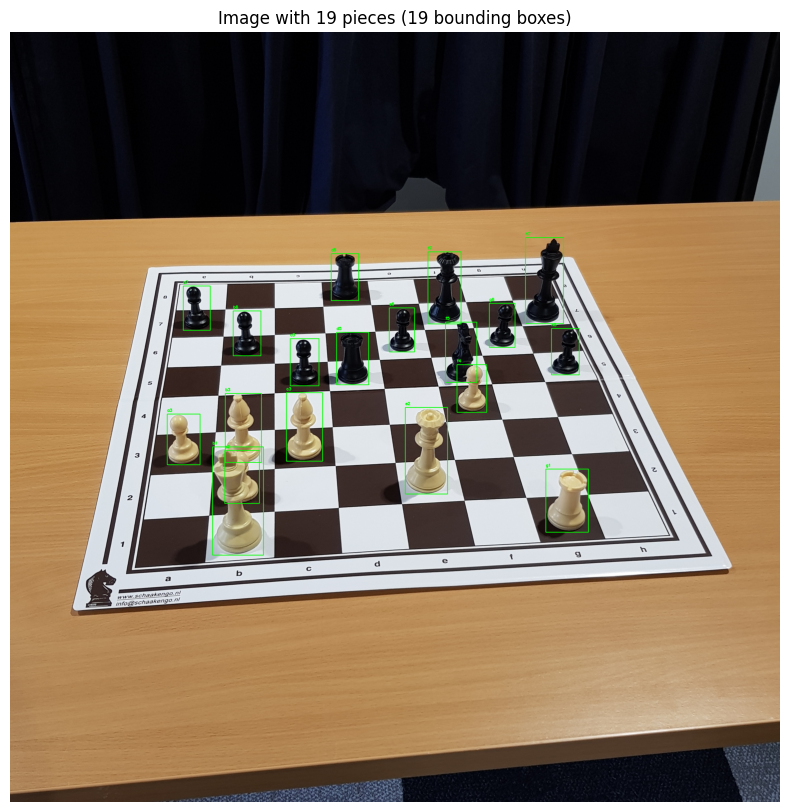

Image 1309 from /kaggle/input/chessred/chessred2k/images/91/G091_IMG070.jpg
Number of pieces: 19
Number of bounding boxes: 19
First annotation: {'bbox': [1261.45, 870.91, 108.46, 184.93], 'category_id': 7, 'position': 'd8'}


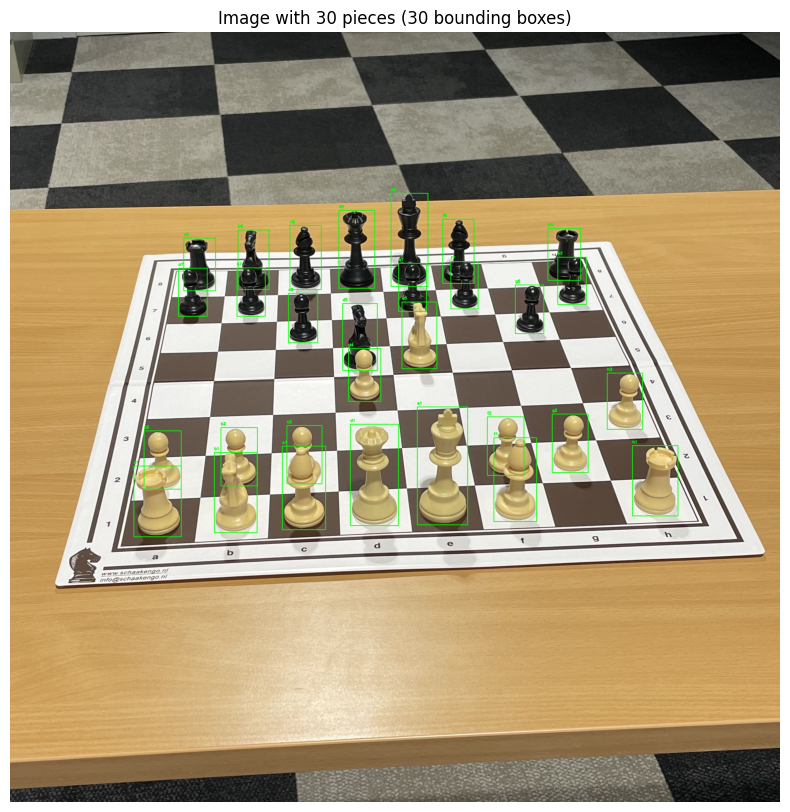

Image 228 from /kaggle/input/chessred/chessred2k/images/28/G028_IMG012.jpg
Number of pieces: 30
Number of bounding boxes: 30
First annotation: {'bbox': [682.59, 809.82, 125.62, 207.03], 'category_id': 7, 'position': 'a8'}


In [25]:
def visualize_sample_with_bboxes(dataset, num_samples=3):
    """
    Visualize samples from the dataset with bounding boxes
    """
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
    for idx in indices:
        img, count, annotations, (h, w), img_path = dataset[idx]
        
        # Skip if it's a placeholder
        if h == 0 or w == 0:
            print(f"Skipping image {idx} (placeholder/error)")
            continue
            
        # Create a copy for drawing
        img_display = img.copy()
        
        # Draw bounding boxes on the image
        for i, ann in enumerate(annotations):
            bbox = ann['bbox']
            x, y, width, height = [int(v) for v in bbox]
            
            # Get category if available
            cat_id = ann.get('category_id', 0)
            cat_name = dataset.category_map.get(cat_id, f"Class {cat_id}")
            
            # Draw rectangle and label
            cv2.rectangle(img_display, (x, y), (x + width, y + height), (0, 255, 0), 2)
            cv2.putText(img_display, ann['position'], (x, y - 10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        # Display the image
        plt.figure(figsize=(12, 10))
        plt.imshow(img_display)
        plt.title(f"Image with {count} pieces ({len(annotations)} bounding boxes)")
        plt.axis('off')
        plt.show()
        
        # Print annotations
        print(f"Image {idx} from {img_path}")
        print(f"Number of pieces: {count}")
        print(f"Number of bounding boxes: {len(annotations)}")
        if annotations:
            print("First annotation:", annotations[0])

# Visualize samples from the training set
print("\nVisualizing samples with bounding boxes:")
visualize_sample_with_bboxes(train_dataset, num_samples=2)

In [26]:
def prepare_yolo_dataset(dataset_dict, output_dir='yolo_chess_dataset'):
    """
    Prepare dataset in YOLO format using the actual bounding box annotations
    with proper handling of category IDs
    
    Args:
        dataset_dict: Dictionary mapping split names to datasets
        output_dir: Directory to save the YOLO format dataset
    
    Returns:
        Path to the YOLO data.yaml file
    """
    print("Preparing YOLO dataset with real bounding boxes...")
    
    # Create necessary directories
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(output_dir, 'images', split), exist_ok=True)
        os.makedirs(os.path.join(output_dir, 'labels', split), exist_ok=True)
    
    # Map our split names to YOLO's expected names
    split_mapping = {'train': 'train', 'valid': 'val', 'test': 'test'}
    
    # Get first dataset to extract category information
    first_dataset = next(iter(dataset_dict.values()))
    
    # Check all unique category IDs in the dataset
    all_category_ids = set()
    for _, dataset in dataset_dict.items():
        for i in range(len(dataset)):
            _, _, annotations, _, _ = dataset[i]
            for ann in annotations:
                if 'category_id' in ann:
                    all_category_ids.add(ann['category_id'])
    
    # Sort category IDs
    sorted_category_ids = sorted(list(all_category_ids))
    print(f"Found {len(sorted_category_ids)} unique category IDs: {sorted_category_ids}")
    
    # Create mapping from original category ID to sequential YOLO class ID (0-based)
    category_id_to_yolo_id = {cat_id: i for i, cat_id in enumerate(sorted_category_ids)}
    
    # Map category IDs to names
    category_names = []
    for cat_id in sorted_category_ids:
        if cat_id in first_dataset.category_map:
            category_names.append(first_dataset.category_map[cat_id])
        else:
            category_names.append(f"class_{cat_id}")
    
    print(f"Category mapping:")
    for cat_id, yolo_id in category_id_to_yolo_id.items():
        name = category_names[yolo_id]
        print(f"  Original ID: {cat_id} -> YOLO ID: {yolo_id} ({name})")
    
    # Process each split
    for split_name, dataset in dataset_dict.items():
        yolo_split = split_mapping.get(split_name, split_name)
        print(f"Processing {split_name} split with {len(dataset)} images...")
        
        # Process each image in the split
        for i in tqdm(range(len(dataset))):
            img, count, annotations, (h, w), img_path = dataset[i]
            
            # Skip images without annotations or dimensions
            if h == 0 or w == 0 or not annotations:
                continue
                
            # Save image with a unique filename
            img_filename = f"{split_name}_{i:06d}.jpg"
            img_output_path = os.path.join(output_dir, 'images', yolo_split, img_filename)
            
            if isinstance(img, np.ndarray):
                cv2.imwrite(img_output_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
            
            # Create YOLO format labels
            label_path = os.path.join(output_dir, 'labels', yolo_split, f"{split_name}_{i:06d}.txt")
            with open(label_path, 'w') as f:
                for ann in annotations:
                    # Get bounding box
                    bbox = ann['bbox']
                    x, y, width, height = bbox
                    
                    # Convert to YOLO format: class_id, x_center, y_center, width, height (normalized)
                    original_category_id = ann['category_id']
                    yolo_class_id = category_id_to_yolo_id.get(original_category_id, 0)  # Default to 0 if not found
                    
                    x_center = (x + width/2) / w
                    y_center = (y + height/2) / h
                    width_norm = width / w
                    height_norm = height / h
                    
                    # Write to file
                    f.write(f"{yolo_class_id} {x_center:.6f} {y_center:.6f} {width_norm:.6f} {height_norm:.6f}\n")
    
    # Create YAML configuration file
    data_yaml_path = os.path.join(output_dir, 'data.yaml')
    with open(data_yaml_path, 'w') as f:
        f.write(f"train: {os.path.join('images', 'train')}\n")
        f.write(f"val: {os.path.join('images', 'val')}\n")
        f.write(f"test: {os.path.join('images', 'test')}\n")
        
        # Write number of classes and names
        f.write(f"nc: {len(category_names)}\n")
        
        # Write class names in proper format
        category_str = "["
        for i, name in enumerate(category_names):
            if i > 0:
                category_str += ", "
            category_str += f"'{name}'"
        category_str += "]"
        f.write(f"names: {category_str}\n")
    
    print(f"YOLO dataset prepared at {output_dir}")
    print(f"Configuration file: {data_yaml_path}")
    print(f"Using {len(category_names)} categories")
    
    return data_yaml_path

# Prepare the YOLO dataset
datasets = {
    'train': train_dataset,
    'valid': valid_dataset,
    'test': test_dataset
}
data_yaml = prepare_yolo_dataset(datasets)

Preparing YOLO dataset with real bounding boxes...
Found 12 unique category IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Category mapping:
  Original ID: 0 -> YOLO ID: 0 (white-pawn)
  Original ID: 1 -> YOLO ID: 1 (white-rook)
  Original ID: 2 -> YOLO ID: 2 (white-knight)
  Original ID: 3 -> YOLO ID: 3 (white-bishop)
  Original ID: 4 -> YOLO ID: 4 (white-queen)
  Original ID: 5 -> YOLO ID: 5 (white-king)
  Original ID: 6 -> YOLO ID: 6 (black-pawn)
  Original ID: 7 -> YOLO ID: 7 (black-rook)
  Original ID: 8 -> YOLO ID: 8 (black-knight)
  Original ID: 9 -> YOLO ID: 9 (black-bishop)
  Original ID: 10 -> YOLO ID: 10 (black-queen)
  Original ID: 11 -> YOLO ID: 11 (black-king)
Processing train split with 1442 images...


100%|██████████| 1442/1442 [02:31<00:00,  9.52it/s]


Processing valid split with 330 images...


100%|██████████| 330/330 [00:34<00:00,  9.48it/s]


Processing test split with 306 images...


100%|██████████| 306/306 [00:32<00:00,  9.40it/s]

YOLO dataset prepared at yolo_chess_dataset
Configuration file: yolo_chess_dataset/data.yaml
Using 12 categories


In [ ]:
def train_yolo_model(data_yaml, model_size='n', epochs=20):
    """
    Train YOLO11 model using the prepared dataset with real bounding boxes
    
    Args:
        data_yaml: Path to data.yaml file
        model_size: YOLO model size ('n', 's', 'm', 'l', 'x')
        epochs: Number of epochs to train
        
    Returns:
        Path to the best model weights
    """
    print(f"Training YOLO11-{model_size} model on dataset with real bounding boxes...")
    print(f"Training will run for {epochs} epochs")
    
    # Initialize model
    model = YOLO(f'yolo11{model_size}.pt')  # Load pretrained model
    
    # Set training parameters
    training_args = {
        'data': data_yaml,          # Path to dataset config
        'epochs': epochs,           # Number of epochs
        'imgsz': 640,               # Image size
        'batch': 16,                # Batch size
        'patience': 0,              # Early stopping patience
        'name': f'chess_detector_real_bbox_{model_size}',  # Run name
        'project': 'runs/detect',   # Project directory
        'device': 0 if device == 'cuda' else 'cpu',  # Device to use
        'verbose': True,            # Verbose output
        'exist_ok': True            # Overwrite existing output
    }
    
    # Train the model
    try:
        results = model.train(**training_args)
        
        # Get the best model path
        best_model_path = f'runs/detect/chess_detector_real_bbox_{model_size}/weights/best.pt'
        if os.path.exists(best_model_path):
            print(f"Training completed successfully.")
            print(f"Best model saved to: {best_model_path}")
            return best_model_path
        else:
            print(f"Training completed, but best model not found at expected path.")
            return None
            
    except Exception as e:
        print(f"Error during training: {str(e)}")
        return None

# Train the model
model_path = train_yolo_model(data_yaml, model_size='m', epochs=20)

Training YOLO11-m model on dataset with real bounding boxes...
Training will run for 20 epochs


100%|██████████| 38.8M/38.8M [00:00<00:00, 267MB/s]


Ultralytics 8.3.140 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_chess_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=chess_detector_real_bbox_m, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=0, perspective=0.0, plots=

train: Scanning /kaggle/working/yolo_chess_dataset/labels/train.cache... 1442 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1442/1442 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1859.9±2105.9 MB/s, size: 1870.3 KB)


val: Scanning /kaggle/working/yolo_chess_dataset/labels/val.cache... 330 images, 0 backgrounds, 0 corrupt: 100%|██████████| 330/330 [00:00<?, ?it/s]


Plotting labels to runs/detect/chess_detector_real_bbox_m/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000625, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/chess_detector_real_bbox_m
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       8.2G     0.6393      1.359     0.8555         89        640: 100%|██████████| 91/91 [01:10<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.78it/s]

                   all        330       6132      0.977      0.975      0.993      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      8.29G     0.4492     0.4146     0.8013         80        640: 100%|██████████| 91/91 [01:09<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.86it/s]

                   all        330       6132      0.988      0.987      0.994      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      8.31G     0.4401     0.3687     0.7991         69        640: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.92it/s]


                   all        330       6132      0.988      0.986      0.994      0.838

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      8.42G     0.4048     0.3347     0.7947         50        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.90it/s]

                   all        330       6132      0.996      0.995      0.995      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      8.39G     0.3874     0.3083      0.794         92        640: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.88it/s]


                   all        330       6132      0.995      0.992      0.995      0.872

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      8.73G     0.3782     0.3013     0.7932         75        640: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.96it/s]

                   all        330       6132      0.993      0.995      0.995       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      8.35G     0.3624     0.2838     0.7894         71        640: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.88it/s]

                   all        330       6132      0.998      0.996      0.995      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20       8.6G      0.364     0.2779     0.7894         31        640: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.86it/s]

                   all        330       6132      0.994      0.995      0.995      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      8.34G     0.3571     0.2697     0.7887         43        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.89it/s]

                   all        330       6132      0.997      0.996      0.994       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      8.41G     0.3472       0.26     0.7878        125        640: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.92it/s]

                   all        330       6132      0.997      0.998      0.995      0.861


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      8.42G     0.3011     0.2204     0.7762         41        640: 100%|██████████| 91/91 [01:11<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.89it/s]

                   all        330       6132      0.992      0.996      0.994      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      8.31G     0.2938     0.2163      0.776         38        640: 100%|██████████| 91/91 [01:08<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.94it/s]


                   all        330       6132      0.994      0.994      0.994      0.868

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      8.15G     0.2811     0.2061     0.7739         60        640: 100%|██████████| 91/91 [01:08<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.85it/s]


                   all        330       6132      0.998      0.999      0.995       0.85

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      8.32G     0.2682     0.1952     0.7725         42        640: 100%|██████████| 91/91 [01:08<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.78it/s]

                   all        330       6132      0.999      0.998      0.995      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      8.69G     0.2636     0.1925     0.7711         64        640: 100%|██████████| 91/91 [01:07<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.91it/s]

                   all        330       6132      0.993      0.997      0.994      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      8.19G     0.2626     0.1903     0.7701         26        640: 100%|██████████| 91/91 [01:08<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.73it/s]

                   all        330       6132      0.996      0.996      0.995      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      8.29G     0.2515     0.1812     0.7697         28        640: 100%|██████████| 91/91 [01:08<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.86it/s]

                   all        330       6132      0.998      0.998      0.995      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      8.19G     0.2511      0.179     0.7696         34        640: 100%|██████████| 91/91 [01:08<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.89it/s]

                   all        330       6132      0.997      0.998      0.995      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      8.42G     0.2461     0.1748     0.7684         32        640: 100%|██████████| 91/91 [01:08<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.90it/s]

                   all        330       6132      0.998      0.997      0.995      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      8.31G     0.2377     0.1677     0.7672         50        640: 100%|██████████| 91/91 [01:08<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.89it/s]

                   all        330       6132      0.998      0.998      0.995       0.87



20 epochs completed in 0.429 hours.
Optimizer stripped from runs/detect/chess_detector_real_bbox_m/weights/last.pt, 40.5MB
Optimizer stripped from runs/detect/chess_detector_real_bbox_m/weights/best.pt, 40.5MB

Validating runs/detect/chess_detector_real_bbox_m/weights/best.pt...
Ultralytics 8.3.140 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m summary (fused): 125 layers, 20,039,284 parameters, 0 gradients, 67.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.02s/it]


                   all        330       6132      0.995      0.992      0.995      0.872
            white-pawn        330       1625          1      0.992      0.995      0.861
            white-rook        281        447          1      0.999      0.995      0.841
          white-knight        220        274          1      0.993      0.995      0.879
          white-bishop        235        335      0.996      0.991      0.994      0.864
           white-queen        126        126      0.979          1      0.995      0.902
            white-king        330        330          1      0.994      0.995      0.918
            black-pawn        330       1511          1      0.986      0.995      0.857
            black-rook        280        471      0.998      0.988      0.995       0.88
          black-knight        125        178          1      0.999      0.995      0.826
          black-bishop        223        380      0.995      0.979      0.994      0.857
           black-quee

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 12.3ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/chess_detector_real_bbox_m
Training completed successfully.
Best model saved to: runs/detect/chess_detector_real_bbox_m/weights/best.pt


In [ ]:
def evaluate_model(model_path, test_dataset):
    """
    Evaluate the trained YOLO model on the test dataset
    
    Args:
        model_path: Path to the trained model
        test_dataset: Test dataset with bounding box annotations
    """
    if not os.path.exists(model_path):
        print(f"Model not found at {model_path}")
        return
        
    print(f"Evaluating model from {model_path} on test data...")
    
    # Load the model
    model = YOLO(model_path)
    
    # Initialize metrics
    results = {
        'predictions': [],
        'ground_truth': [],
        'absolute_errors': [],
        'squared_errors': []
    }
    
    # Create test dataloader
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    # Process each test image
    for i, (img, gt_count, annotations, dims, img_path) in enumerate(tqdm(test_loader)):
        # Get image
        if isinstance(img, list):
            img = img[0]
        elif isinstance(img, torch.Tensor):
            img = img.numpy()[0]
            
        # Get ground truth count
        gt_count = int(gt_count.item())
        
        # Skip invalid images
        if img.size == 0 or dims[0].item() == 0:
            continue
            
        # Run inference
        detection_results = model(img, conf=0.50)  # Lower threshold to detect more pieces
        
        # Count detections
        pred_count = len(detection_results[0].boxes)
        
        # Store results
        results['predictions'].append(pred_count)
        results['ground_truth'].append(gt_count)
        results['absolute_errors'].append(abs(pred_count - gt_count))
        results['squared_errors'].append((pred_count - gt_count) ** 2)
        
        # Print progress every 50 images
        if (i + 1) % 50 == 0:
            current_mae = np.mean(results['absolute_errors'])
            print(f"Processed {i+1} images. Current MAE: {current_mae:.4f}")
    
    # Calculate final metrics
    mae = np.mean(results['absolute_errors'])
    mse = np.mean(results['squared_errors'])
    rmse = np.sqrt(mse)
    
    print("\nTest Results:")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
    
    # Break down results by number of pieces
    ranges = [(1, 5), (6, 10), (11, 15), (16, 20), (21, 32)]
    for low, high in ranges:
        # Get indices of images with piece count in this range
        indices = [i for i, c in enumerate(results['ground_truth']) if low <= c <= high]
        
        if indices:
            range_abs_errors = [results['absolute_errors'][i] for i in indices]
            range_mae = np.mean(range_abs_errors)
            print(f"MAE for {low}-{high} pieces: {range_mae:.4f} (n={len(indices)})")
    
    # Plot error distribution
    plt.figure(figsize=(10, 6))
    plt.hist(results['absolute_errors'], bins=10, edgecolor='black')
    plt.title('Distribution of Absolute Errors')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Plot predictions vs. ground truth
    plt.figure(figsize=(10, 6))
    plt.scatter(results['ground_truth'], results['predictions'], alpha=0.5)
    
    # Add perfect prediction line
    max_val = max(max(results['ground_truth']), max(results['predictions']))
    plt.plot([0, max_val], [0, max_val], 'r--')
    
    plt.title('Predicted vs. Ground Truth Piece Counts')
    plt.xlabel('Ground Truth')
    plt.ylabel('Predicted')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return results

# Evaluate the model (replace with your trained model path if needed)
if model_path and os.path.exists(model_path):
    evaluation_results = evaluate_model(model_path, test_dataset)
else:
    print("No model available for evaluation. Please train the model first.")


Visualizing model predictions:

--- Image 298 ---
Path: /kaggle/input/chessred/chessred2k/images/76/G076_IMG092.jpg
Actual piece count: 13
Number of ground truth bounding boxes: 13

0: 640x640 6 white-pawns, 2 white-rooks, 1 white-king, 4 black-pawns, 1 black-rook, 1 black-king, 16.0ms
Speed: 3.3ms preprocess, 16.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Predicted piece count: 15
Error: 2


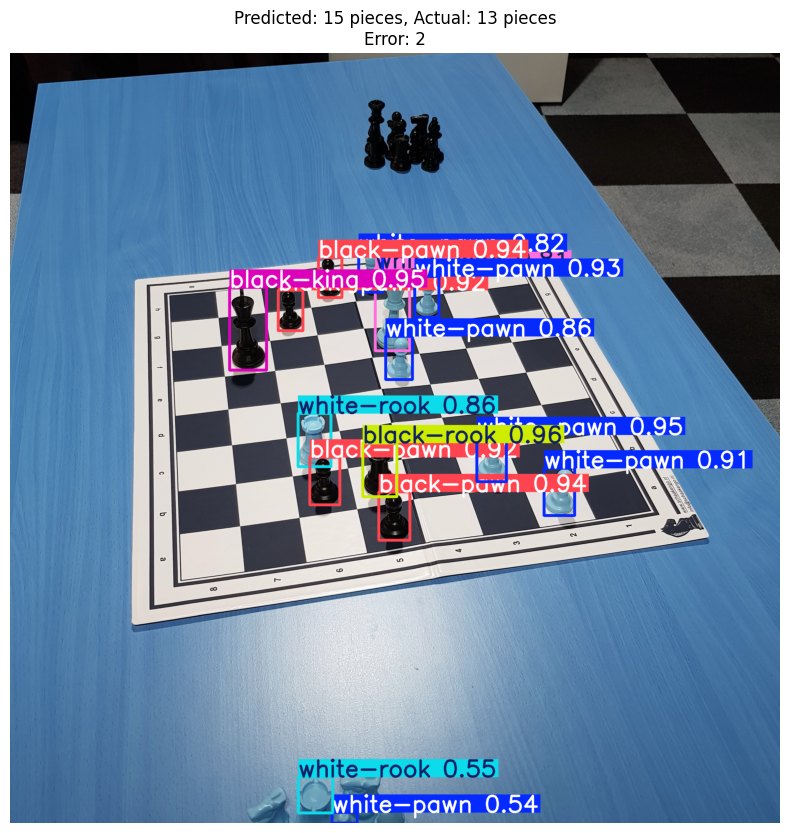


--- Image 111 ---
Path: /kaggle/input/chessred/chessred2k/images/33/G033_IMG008.jpg
Actual piece count: 32
Number of ground truth bounding boxes: 32

0: 640x640 8 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 8 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 16.1ms
Speed: 3.6ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Predicted piece count: 32
Error: 0


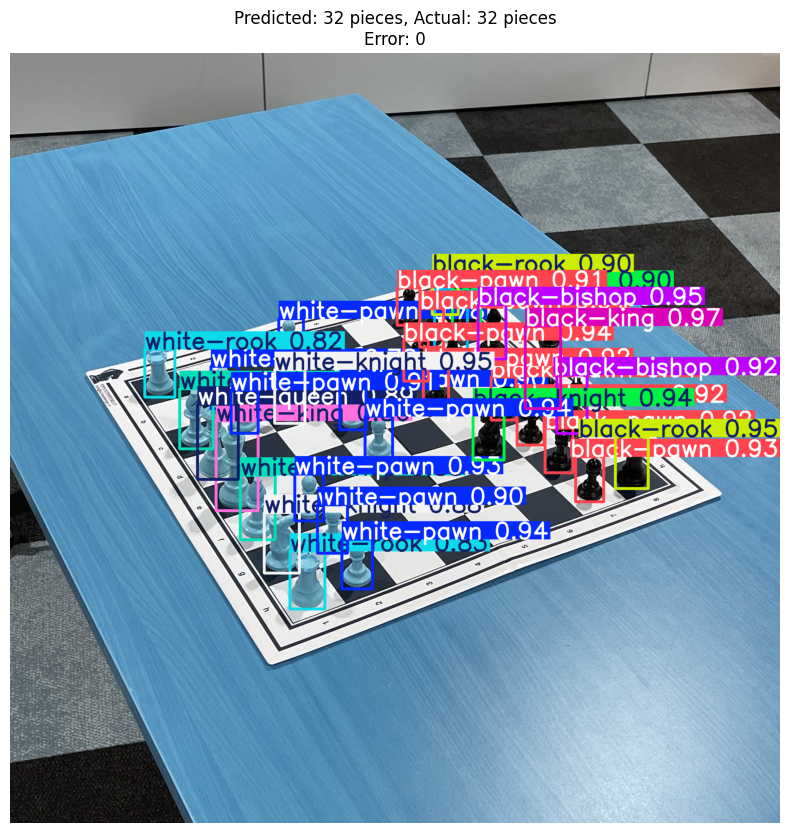


--- Image 258 ---
Path: /kaggle/input/chessred/chessred2k/images/76/G076_IMG052.jpg
Actual piece count: 19
Number of ground truth bounding boxes: 19

0: 640x640 5 white-pawns, 1 white-rook, 1 white-bishop, 1 white-queen, 1 white-king, 5 black-pawns, 1 black-rook, 1 black-bishop, 1 black-queen, 1 black-king, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Predicted piece count: 18
Error: 1


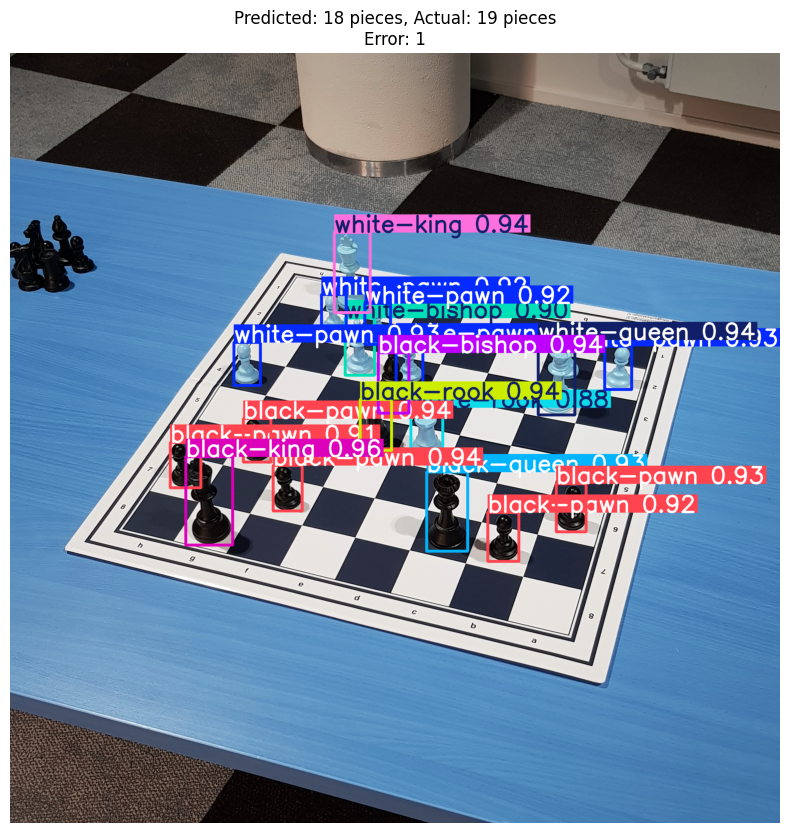


--- Image 71 ---
Path: /kaggle/input/chessred/chessred2k/images/0/G000_IMG071.jpg
Actual piece count: 15
Number of ground truth bounding boxes: 15

0: 640x640 7 white-pawns, 2 white-rooks, 1 white-knight, 2 white-bishops, 1 white-queen, 1 white-king, 6 black-pawns, 2 black-rooks, 1 black-knight, 2 black-bishops, 1 black-queen, 2 black-kings, 16.1ms
Speed: 3.6ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Predicted piece count: 28
Error: 13


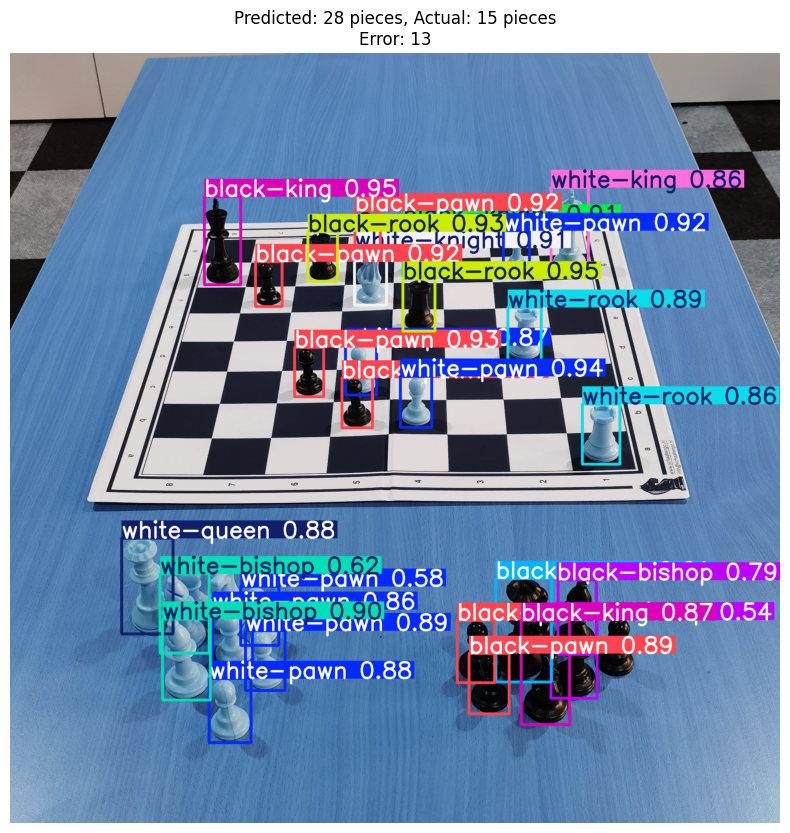


--- Image 144 ---
Path: /kaggle/input/chessred/chessred2k/images/33/G033_IMG041.jpg
Actual piece count: 25
Number of ground truth bounding boxes: 25

0: 640x640 5 white-pawns, 2 white-rooks, 1 white-knight, 2 white-bishops, 1 white-queen, 1 white-king, 6 black-pawns, 2 black-rooks, 1 black-knight, 2 black-bishops, 1 black-queen, 1 black-king, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Predicted piece count: 25
Error: 0


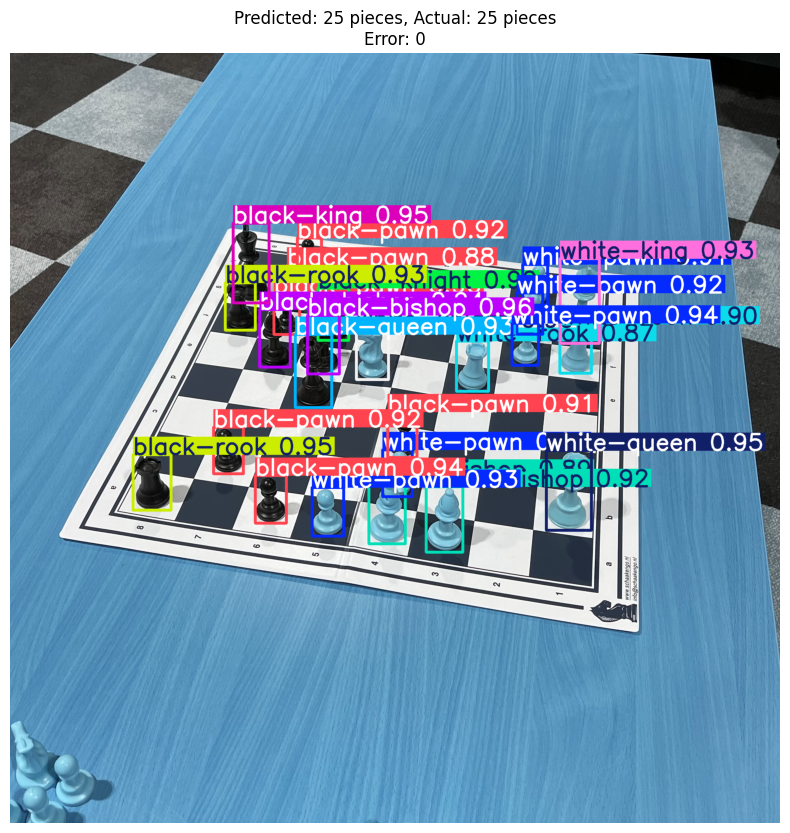

In [29]:
def visualize_predictions(model_path, test_dataset, num_samples=5):
    """
    Visualize model predictions on test images
    
    Args:
        model_path: Path to the trained model
        test_dataset: Test dataset
        num_samples: Number of samples to visualize
    """
    if not os.path.exists(model_path):
        print(f"Model not found at {model_path}")
        return
        
    # Load the model
    model = YOLO(model_path)
    
    # Randomly sample images
    indices = random.sample(range(len(test_dataset)), min(num_samples, len(test_dataset)))
    
    for idx in indices:
        # Get sample
        img, gt_count, annotations, (h, w), img_path = test_dataset[idx]
        
        # Skip invalid images
        if h == 0 or w == 0:
            continue
            
        print(f"\n--- Image {idx} ---")
        print(f"Path: {img_path}")
        print(f"Actual piece count: {gt_count}")
        print(f"Number of ground truth bounding boxes: {len(annotations)}")
        
        # Run inference
        results = model(img, conf=0.50)
        pred_count = len(results[0].boxes)
        
        print(f"Predicted piece count: {pred_count}")
        print(f"Error: {abs(pred_count - gt_count)}")
        
        # Get annotated image with detections
        annotated_img = results[0].plot()
        
        # Display
        plt.figure(figsize=(12, 10))
        plt.imshow(annotated_img[..., ::-1])  # Convert BGR to RGB
        plt.title(f"Predicted: {pred_count} pieces, Actual: {gt_count} pieces\nError: {abs(pred_count - gt_count)}")
        plt.axis('off')
        plt.show()

# Visualize predictions
if model_path and os.path.exists(model_path):
    print("\nVisualizing model predictions:")
    visualize_predictions(model_path, test_dataset, num_samples=5)
else:
    print("No model available for visualization. Please train the model first.")